# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

20360


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## Refgen for gene dist matrix

Example of [refgen](../0_locus_annotation/resources/refgen_df_for_jie.csv)

In [9]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


In [10]:
chrom_number = []
for i, row in df_refgen.iterrows():
    if ('X' in row.chr):
        chrom_number.append(20)
    elif ('Y' in row.chr):
        chrom_number.append(21)
    else:
        chrom_number.append(int(row['chr'].split('chr')[-1]))
df_refgen['chrom_number'] = chrom_number
df_refgen.sort_values(['chrom_number','hyb'], inplace=True, ignore_index=True)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id,chrom_number
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2,1
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3,1
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4,1
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5,1


In [11]:
from scipy.spatial.distance import squareform, pdist
chr_gene_dist_matrices = {}
for chrom, df_chr in df_refgen.groupby('chr'):
    if 'Y' not in chrom:
        _df = df_chr.sort_values('hyb')
        _delta_values= np.zeros((len(_df),2))
        _delta_values[:,0] = _df.delta.values
        _gene_dist = squareform(pdist(_delta_values))
        chr_gene_dist_matrices[chrom] = _gene_dist

# 3. Load activity density result

Data can be generated from the notebook

[9_marker_gene_ab_trans_density_between_neurons_analysis](9_marker_gene_ab_trans_density_between_neurons_analysis.ipynb)

In [23]:
_groupby_savename = 'subclass'
norm_compiled_df_savename = os.path.join(output_analysis_folder,f'{_groupby_savename}_marker_AB_trans_ratio_regressed_heatmap_norm_th_zero.csv')
norm_compiled_df = pd.read_csv(norm_compiled_df_savename)

_groupby_savename = 'neuron'

In [24]:
norm_compiled_df

,loci_name,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L6 CT,L5/6 NP,L6b,Vip,Pvalb,Lamp5,Sst,Sncg,Marker_gene,Marker_group,Expression_change
0,chr1_55447113_55457262,0.000000,0.011063,0.021120,0.009726,-0.146763,-0.325399,-0.148422,0.247882,-0.005598,-0.106372,0.057442,-0.141804,-0.410788,Plcl1,L2/3 IT,upregulated
1,chr1_57812315_57822455,0.000000,-0.057513,-0.005541,-0.093409,-0.470501,-0.366722,-0.474251,-0.150979,-0.540396,0.008008,-0.149224,-0.246708,0.105917,Spats2l,L2/3 IT,upregulated
2,chr1_83353943_83364452,0.000000,-0.054571,-0.043101,-0.052076,-0.241306,-0.170686,-0.202272,-0.140220,-0.216036,0.001272,0.096791,-0.123689,-0.322728,Sphkap,L2/3 IT,upregulated
3,chr2_83746826_83759988,0.000000,-0.020534,-0.016832,0.035450,-0.034205,-0.101850,0.370106,-0.149193,0.569380,0.007090,-0.002261,0.356729,-0.098823,Itgav,L2/3 IT,upregulated
4,chr2_118752499_118759998,0.000000,-0.057859,-0.189914,0.050699,0.108215,-0.071017,-0.118075,0.076688,0.331527,0.355180,0.238286,0.290521,0.981689,Pak6,L2/3 IT,upregulated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,chr15_93506606_93516280,-0.251948,-0.180933,-0.238832,-0.301067,-0.306293,-0.091710,-0.096396,-0.174574,-0.343792,-0.175857,-0.209146,-0.412901,0.000000,Prickle1,Sncg,downregulated
942,chr16_67578897_67609116,-0.137487,-0.127579,-0.073092,-0.054290,0.137218,-0.093890,-0.101289,-0.172883,-0.186030,-0.187594,-0.029203,-0.062741,0.000000,Cadm2,Sncg,downregulated
943,chr18_6969332_6981478,0.210980,0.231961,0.264267,0.141618,0.411606,0.165765,0.217344,0.127635,0.285894,0.204788,0.499079,0.134392,0.000000,Mkx,Sncg,downregulated
944,chr18_24800347_24810452,-0.208381,-0.063688,-0.020540,-0.123118,0.083217,-0.081543,-0.149291,-0.025071,-0.058653,-0.404812,-0.008137,-0.159003,0.000000,Fhod3,Sncg,downregulated


meta NOT subset; don't know how to subset; dropped


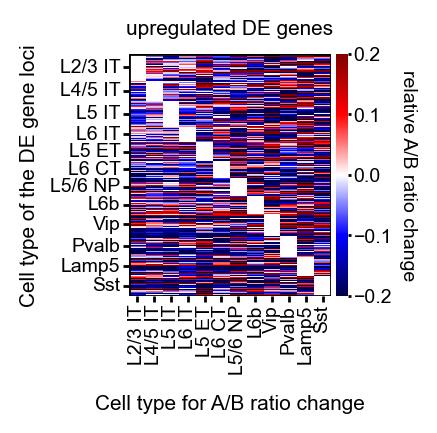

meta NOT subset; don't know how to subset; dropped


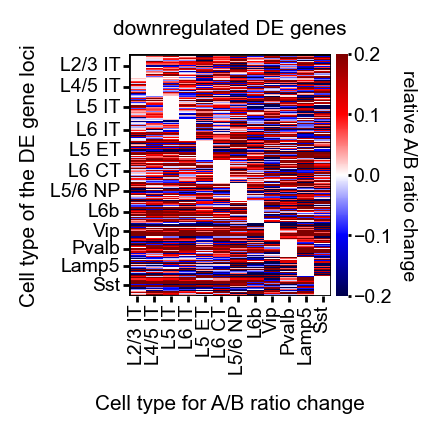

In [26]:
%matplotlib inline

#plt.style.use('dark_background')
#plt.style.use('default')
sorted_group_order = ['L2/3 IT', 'L4/5 IT', 'L5 IT',
       'L6 IT', 'L5 ET', 'L6 CT', 'L5/6 NP', 'L6b', 'Vip', 'Pvalb', 'Lamp5',
       'Sst', ]

for _dir in ['upregulated','downregulated']:
    
    fig, ax = plt.subplots(1, 1, figsize=(_page_width/3.5, _page_width/3.5) , dpi=200, sharex=True, sharey=True)
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    sub_compiled_df = sub_compiled_df[sub_compiled_df['Marker_group'].isin(sorted_group_order)]
    mat_df = sub_compiled_df[sorted_group_order]
    mat_plot = mat_df.to_numpy()
    #mat_df = np.log2(mat_df)

    #sns.heatmap(mat_df,vmin=-np.log2(1.2), vmax=np.log2(1.2), cmap='PiYG_r', 
                #ax=ax, cbar_kws={'label':'A/B ratio fold change', "pad": 0.02})
    sns.heatmap(mat_df,vmin=-0.2, vmax=0.2, cmap='seismic', 
                ax=ax, cbar_kws={'label':'A/B ratio fold change', "pad": 0.02},linewidth=0.0)
    #_im = ax.imshow(SE_ratio_mat, vmin=0.99, vmax=1.05, cmap='viridis')
    #vmin, vmax = 0.8, 1.25

    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns))+0.5)
    ax.set_xticklabels(labels = mat_df.columns,fontsize=_font_size-0.5,
               rotation=90)

    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    group_nums = np.array(sub_compiled_df.groupby(['Marker_group'],sort=False).size().tolist())
    group_edges = np.cumsum(group_nums)
    yticks = (group_edges[1:] + group_edges[:-1])/2
    yticks = np.insert(yticks,0, int(group_nums[0]/2))
    yticks=[(_t-0.5) for _t in yticks]
    ax.set_yticks(ticks = yticks)
    ytick_labels  = [f'{_l}' for _l in group_plot]
    ax.set_yticklabels(labels = ytick_labels, fontsize=_font_size-0.5,
                       #width=_ticklabel_width, 
                       #length=_ticklabel_size,
               rotation=0)


    ax.tick_params('x', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    labeltop=False,
                    pad=1, )
    ax.tick_params('y', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    #labeltop=False,
                    pad=1, )
    ax.figure.axes[-1].tick_params(axis='y', length=1, pad=1, labelsize=_font_size-0.5,)
    ax.figure.axes[-1].set_ylabel('relative A/B ratio change', fontsize=_font_size-0.5, rotation=270, labelpad=9)
    
    ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=mat_plot.shape[0], color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=mat_plot.shape[1], color='k',linewidth=1)
    
    ax.set_title(f'{_dir} DE genes', fontsize=_font_size,pad=7)
    ax.set_xlabel('Cell type for A/B ratio change', fontsize=_font_size,labelpad=7)
    ax.set_ylabel('Cell type of the DE gene loci', fontsize=_font_size)
    
    plt.savefig(os.path.join(output_figure_folder,
                             f'Marker_gene_{_groupby_savename}_{_dir}_AB_density_change_heatmap_th_zero.pdf'),
                transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)

    plt.show()

## Reduce loci for each marker group to its median

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_20360\1298931947.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_20360\1298931947.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
meta NOT subset; don't know how to subset; dropped


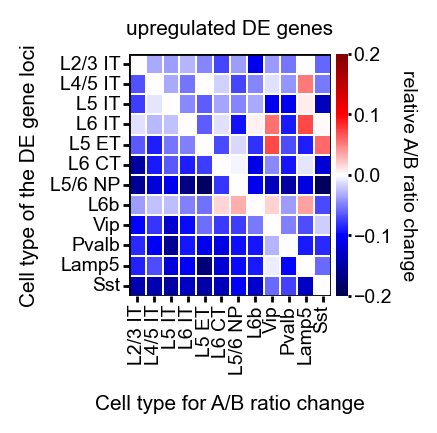

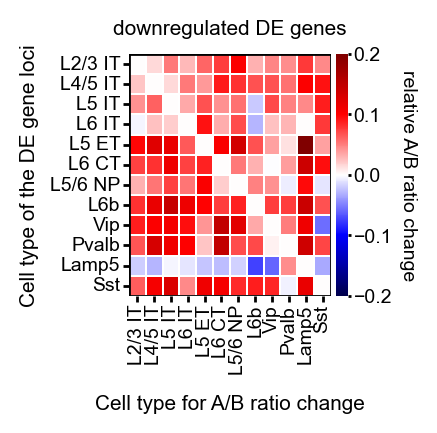

In [21]:
%matplotlib inline


#sns.set(font_scale=1)

for _dir in ['upregulated','downregulated']:
    fig, ax = plt.subplots(1, 1, figsize=(_page_width/3.5, _page_width/3.5) , dpi=200, sharex=True, sharey=True)
    
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    sub_compiled_df = sub_compiled_df[sub_compiled_df['Marker_group'].isin(sorted_group_order)]
    mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
    mat_plot = mat_df.to_numpy()
    #mat_df = np.log2(mat_df)

    sns.heatmap(mat_df,vmin=-0.2, vmax=0.2, cmap='seismic', 
                ax=ax, cbar_kws={'label':'A/B ratio fold change', "pad": 0.02},linewidth=0.01)

    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns))+0.5)
    ax.set_xticklabels(labels = mat_df.columns,fontsize=_font_size-0.5,
               rotation=90)

    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    ax.set_yticks(ticks = np.arange(len(group_plot))+0.5)
    ytick_labels  = group_plot
    ax.set_yticklabels(labels = ytick_labels,fontsize=_font_size-0.5,
               rotation=0)
    
    
    ax.tick_params('x', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    labeltop=False,
                    pad=1, )
    ax.tick_params('y', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    #labeltop=False,
                    pad=1, )
    ax.figure.axes[-1].tick_params(axis='y', length=1, pad=1, labelsize=_font_size-0.5,)
    ax.figure.axes[-1].set_ylabel('relative A/B ratio change', fontsize=_font_size-0.5, rotation=270, labelpad=9)

    ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=mat_plot.shape[0], color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=mat_plot.shape[1], color='k',linewidth=1)

    
    ax.set_title(f'{_dir} DE genes', fontsize=_font_size,pad=7)
    ax.set_xlabel('Cell type for A/B ratio change', fontsize=_font_size,labelpad=7)
    ax.set_ylabel('Cell type of the DE gene loci', fontsize=_font_size)
    
    plt.savefig(os.path.join(output_figure_folder,f'Marker_gene_{_groupby_savename}_{_dir}_AB_density_change_heatmap_th_zero_REDUCED.pdf'),
                transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)




## Stats for heatmap (all loci)

In [56]:
%matplotlib inline
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as multitest

#plt.style.use('dark_background')
#plt.style.use('default')
sorted_group_order = ['L2/3 IT', 'L4/5 IT', 'L5 IT',
       'L6 IT', 'L5 ET', 'L6 CT', 'L5/6 NP', 'L6b', 'Vip', 'Pvalb', 'Lamp5',
       'Sst', ]

stats_group_dict = {}
for _marker_group in sorted_group_order:
    _marker_df = norm_compiled_df[norm_compiled_df['Marker_group']==_marker_group]
    
    stats_groups = []
    for _dir in ['upregulated','downregulated']:
        sub_marker_df = _marker_df[_marker_df['Expression_change']==_dir]
        sub_marker_vals = sub_marker_df[[g for g in sorted_group_order if g!=_marker_group]] # remove itself
        sub_marker_vals = sub_marker_vals.to_numpy().flatten()
        sub_marker_vals = sub_marker_vals[np.isfinite(sub_marker_vals)]
        stats_groups.append(sub_marker_vals)
    p = mannwhitneyu(stats_groups[0],stats_groups[1], alternative="less",)[1]
    stats_group_dict[_marker_group] = p
        

adj_pvals = multitest.fdrcorrection(list(stats_group_dict.values()), alpha=0.05, method='indep', is_sorted=False)[1]
adj_pvals

array([3.75626141e-22, 5.54521567e-12, 3.97186427e-19, 2.35803268e-06,
       1.09384722e-11, 1.32320196e-38, 3.71925599e-27, 5.99894641e-17,
       1.06417598e-14, 4.29508188e-31, 1.43664916e-06, 2.83594350e-37])